# Calculate the AVR as a function of effective temperature.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from dispersion import *

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Gaia-McQuillan crossmatch and make cuts.

In [73]:
gaia_mc0 = pd.read_csv("gaia_mc.csv")
print(np.shape(gaia_mc0))

# Cut out visual binaries.
gaia_mc1 = gaia_mc0.iloc[gaia_mc0.flag.values == 1]
print(np.shape(gaia_mc1), "no visual binaries or subgiants")

# Cut out stars with large vb uncertainties.
m = gaia_mc1.vb_err.values < 1.
print(np.shape(gaia_mc1.iloc[m]), "no large vb uncertainties")

m &= gaia_mc1.phot_g_mean_mag.values < 16.
print(np.shape(gaia_mc1.iloc[m]), "no faint stars")

# Cut out rapid rotators (synchronized binaries)
m &= gaia_mc1.age.values > .5
print(np.shape(gaia_mc1.iloc[m]), "no rapid rotators")

# Cut out very hot and very cold stars
m &= (gaia_mc1.color_teffs.values < 7000) * (3500 < gaia_mc1.color_teffs.values)
print(np.shape(gaia_mc1.iloc[m]), "no hot or cold stars")

gaia_mc = gaia_mc1.iloc[m]

(29727, 155)
(10544, 155) no visual binaries or subgiants
(10405, 155) no large vb uncertainties
(10274, 155) no faint stars
(9684, 155) no rapid rotators
(9595, 155) no hot or cold stars


Make cuts in log age.

In [74]:
age_bins = 10**np.linspace(np.log10(.5), np.log10(3.5), 7)
mid_age_bins = age_bins[:-1] + .5*np.diff(age_bins)
age_masks = select_stars(gaia_mc, age_bins, "age")

Format data.

In [75]:
x = gaia_mc.color_teffs.values
y = gaia_mc.Prot.values
v = gaia_mc.vb.values
verr = gaia_mc.vb_err.values
xerr = np.ones_like(x)*100

tbins = np.linspace(min(x), max(x), 10)
mid_tbins = .5*np.diff(tbins) + tbins[:-1]
ds, derrs = [np.zeros((len(age_bins), len(tbins[:-1]))) for i in range(2)]

Calculate dispersion as a function of age and temperature.

In [76]:
for i, m in enumerate(age_masks):
    v_clipped, clipping_mask = sigma_clip(v[m], 3)
    d, derr, k, kerr = MC_dispersion(x[m][clipping_mask], v_clipped, xerr[m][clipping_mask], 
                                     verr[m][clipping_mask],
                                     tbins, 1000, method="std")
    ds[i, :] = d
    derrs[i, :] = err_on_sample_std_dev(d, len(x[m][clipping_mask]))
#     derrs[i, :] = derr

  6%|▋         | 64/1000 [00:00<00:01, 632.94it/s]

niter =  3 10 stars removed kurtosis =  0.039524209144258915


  7%|▋         | 67/1000 [00:00<00:01, 666.12it/s]

niter =  2 4 stars removed kurtosis =  -0.2669446058795635


  7%|▋         | 72/1000 [00:00<00:01, 715.15it/s]

niter =  3 6 stars removed kurtosis =  -0.4172537338853286


  6%|▋         | 63/1000 [00:00<00:01, 624.49it/s]

niter =  2 7 stars removed kurtosis =  -0.062469327922207274


 12%|█▏        | 115/1000 [00:00<00:01, 556.14it/s]

niter =  5 20 stars removed kurtosis =  0.14845744846792286


  6%|▌         | 55/1000 [00:00<00:01, 547.03it/s]

niter =  4 19 stars removed kurtosis =  0.1418816813903674


100%|██████████| 1000/1000 [00:01<00:00, 586.28it/s]


Calculate the AVR for each temperature bin (ds = [age_bins, tbins-1]). Exclude the oldest and youngest bins from the fit.

Text(0, 0.5, '$\\mathrm{\\sigma_{vb}}$')

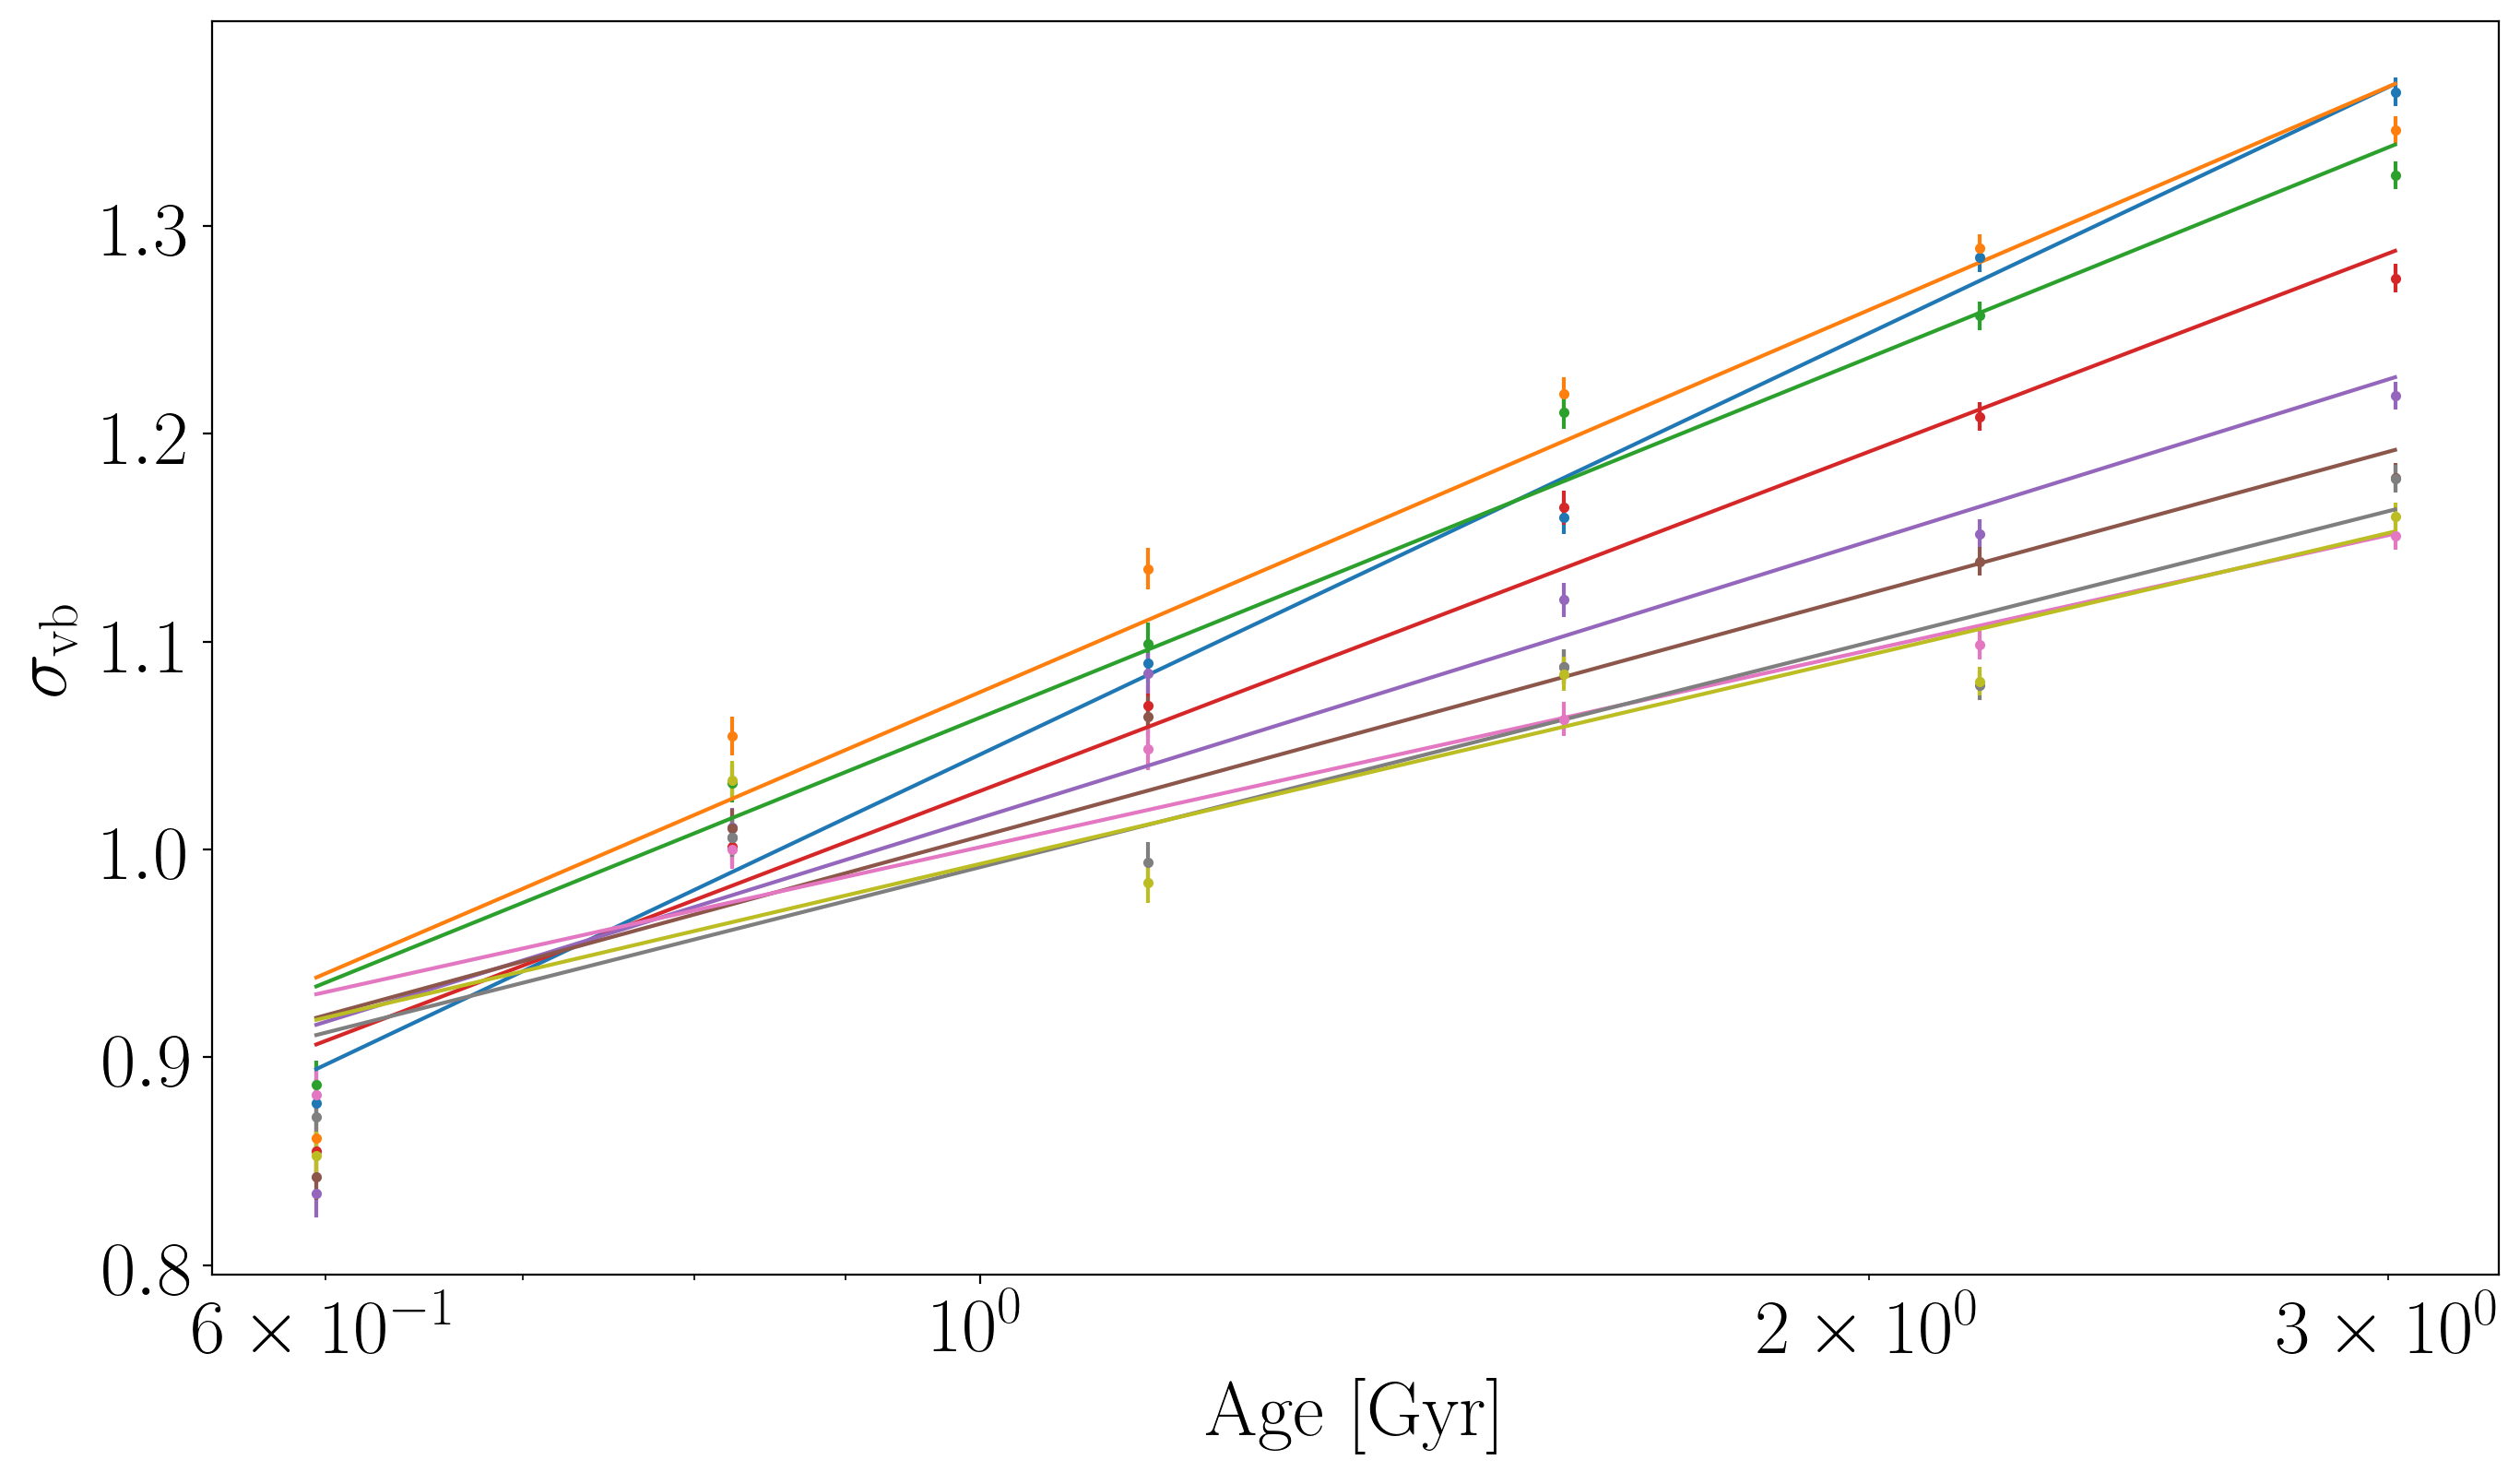

In [77]:
plt.figure(figsize=(16, 9), dpi=200)

x = (np.log10(mid_age_bins))
z = mid_tbins

w1s, w1errs = [np.zeros(len(z)) for i in range(2)]
for i in range(len(z)):
    
    y = np.log10(ds[:, i][:-1])
    yerr = err_to_log10_err(ds[:, i][:-1], derrs[:, i][:-1])
    
    w, wcovar = fit_line(x, y, yerr)
    w1s[i] = w[1]
    w1errs[i] = np.sqrt(wcovar[1, 1])
    
    plt.errorbar(10**x, y, yerr=yerr, fmt=".", color="C{}".format(i))
    plt.plot(10**x, w[0] + w[1]*x, color="C{}".format(i))

plt.xscale("log")
plt.xlabel("$\mathrm{Age~[Gyr]}$")
plt.ylabel("$\mathrm{\sigma_{vb}}$")

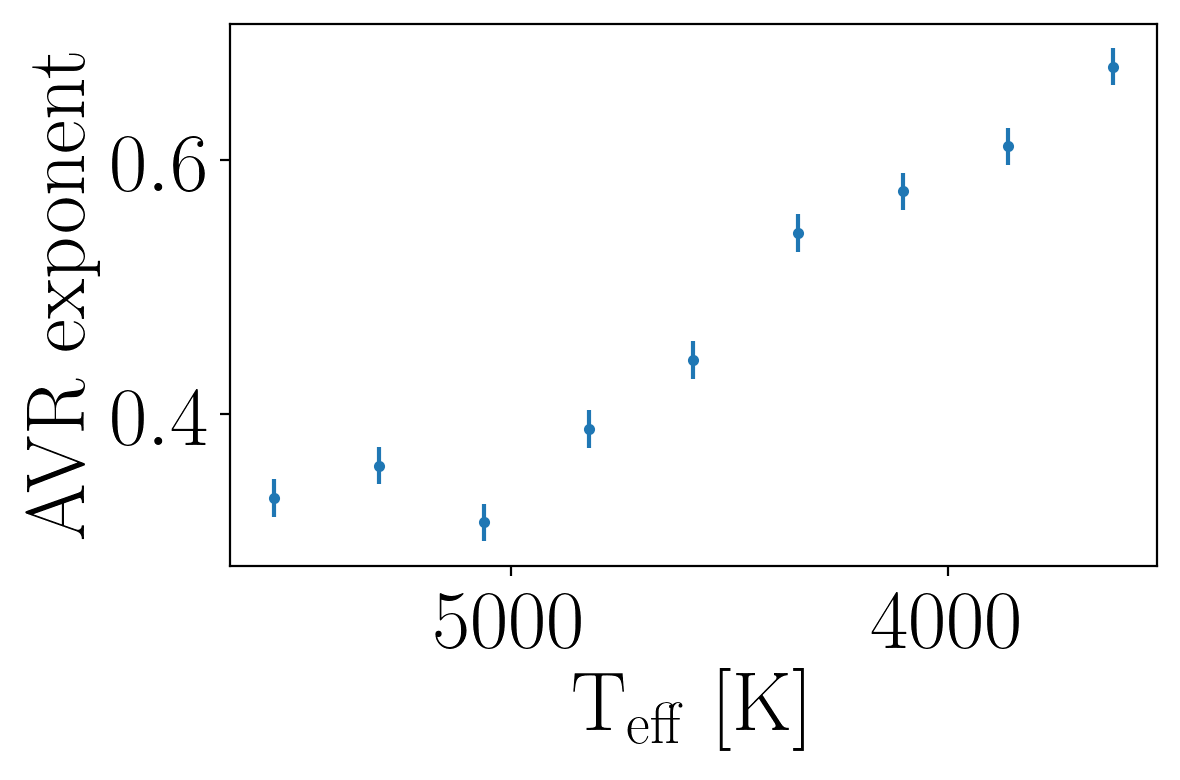

In [78]:
plt.figure(dpi=200)
plt.errorbar(mid_tbins, w1s, yerr=w1errs, fmt=".")
plt.xlim(max(mid_tbins)+100, min(mid_tbins)-100)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{AVR~exponent}$")
plt.tight_layout()
plt.savefig("paper/AVR_exponent.pdf")

In [58]:
print("minimum beta = {0:.2f} +\- {1:.2f}".format(w1s[-1], w1errs[-1]))
print("maximum beta = {0:.2f} +\- {1:.2f}".format(w1s[0], w1errs[0]))

minimum beta = 0.39 +\- 0.02
maximum beta = 0.74 +\- 0.02


In [59]:
print(tbins)

[3501.36676514 3667.86374796 3834.36073077 4000.85771359 4167.35469641
 4333.85167923 4500.34866205 4666.84564486 4833.34262768 4999.8396105 ]
